# **Diversion Data Exploratory Analysis**

Author: Bridget Bittmann

Date Created: 09/14/2021

Date Modified: 01/14/2022

In [14]:
#Import necessary packages

import pandas as pd #to work with data arrays
import numpy as np #to work with arrays and statistics
import matplotlib.pyplot as plt #create graphs 
from matplotlib.dates import DateFormatter #to help with timeseries
import glob #to batch import csv files
from sklearn import metrics #to find r2 values from regression
!pip install pymannkendall
import pymannkendall as mk #used to perform mann-kendall stationarity test
from sklearn.cluster import KMeans #to cluster using kmeans

In [15]:
#Navigate to your directory

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#Navigate to workspace

%cd /content/drive/MyDrive/spatial_colab/
%ls

/content/drive/MyDrive/spatial_colab
1986.tif  1988.tif  1990.tif  1992.tif  datasets/
1987.tif  1989.tif  1991.tif  1993.tif  pod_pou_lulcc/


In [17]:
#Import data files
#Can comment after first run 

# div_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63.csv', parse_dates=['DiversionDate'], index_col=['DiversionDate'])
# full_wd63 = pd.read_csv('datasets/diversion_timeseries/WD63_WRA_all.csv', parse_dates=['DataDate'], index_col=['DataDate'])
# print(div_wd63.dtypes)
# print(full_wd63.dtypes)

In [18]:
## RENAME THE COLUMNS TO MATCH OLD TIMESERIES DESCRIPTIONS
## Can comment out after first run

# full_wd63 = full_wd63.rename(columns={'SiteID':'HydrologyID', 'FullName':'DiversionName',
#                                       'Description':'DiversionTypeDescription', 'DataDate':'DiversionDate'})

# ## replace SURPRISE VALLEY/MICRON with surprise_vy_micron to export CSV

# full_wd63['DiversionName'] = full_wd63['DiversionName'].replace(to_replace='SURPRISE VALLEY/MICRON',
#                                                                 value='SURPRISE_VALLEY_MICRON')

In [19]:
### CREATE A CSV FILE FOR EACH DIVERSION ###

#This section is useful to clean, sort, and individually export each csv
#Can comment section out after first run 

# div_name = np.unique(full_wd63['DiversionName']) #get unique identifier for each div point
# print(div_name)

# for n in div_name:
#   canal = full_wd63[full_wd63['DiversionName']== n] #creates a dataframe for each canal name
#   canal = canal.sort_index() #sorts data by date
#   file_name = 'datasets/diversion_timeseries/fulltime_individual_canals/'+ str(n) +'.csv' #creates a file path
#   canal.to_csv(file_name) #exports csv to directory

In [20]:
### IMPORT ALL NEW CSV FILES INTO ONE DATAFRAME ###

all_files = [] #creates a list space for all the dataframes

csv = glob.glob('datasets/diversion_timeseries/fulltime_individual_canals/*.csv') #name for all the csv files
for f in csv: 
  df = pd.read_csv(f, parse_dates=['DataDate'], index_col=['DataDate'])
  all_files.append(df) #appends dataframes to one file list

In [21]:
#Plot the data to see the timescale

###----------------------------------###
### CREATES ONE FIGURE FOR ALL PLOTS ###
###----------------------------------###

# len(all_files)
# i,j = 0,0
# plot_row = 4 #number of plots per row in figure
# figure, ax = plt.subplots(33, plot_row, figsize=(30,150)) #create the figure
# file_len = np.array(np.arange(0,len(all_files),1)) #total count of files

# for f in file_len: #run a for loop to add all plots to figure
#   canal_data = all_files[f] #takes an individual diversion point datafram
#   ax[i][j].plot(canal_data.index, canal_data['CFS'], 'o')
#   ax[i][j].set_ylabel('Discharge (cfs)')
#   ax[i][j].set_xlabel('Time')
#   ax[i][j].title.set_text(canal_data['DiversionName'].iloc[0])
#   j+=1
#   if j%plot_row==0:
#     i+=1
#     j=0

# ###---------------------------------------------###
# ### CREATES INDIVIDUAL PLOTS FOR EACH DIVERSION ###
# ###---------------------------------------------###

# for f in file_len:
#   canal_data = all_files[f]
#   fig = plt.figure(figsize= (9,7))
#   ax = fig.add_subplot(1,1,1)
#   ax.plot(canal_data.index, canal_data['CFS'], 'o')
#   ax.set_ylabel('Discharge (cfs)')
#   ax.set_xlabel('Time')
#   ax.title.set_text(canal_data['DiversionName'].iloc[0])
#   file_path = ('datasets/diversion_timeseries/individualplots/'+ canal_data['DiversionName'].iloc[0] +'.png')
#   plt.savefig(file_path) #exports the file 


In [22]:
## DATA QUALITY CONTROL PRIOR TO ANALYSIS ##

## Select only the diversions known to serve irrigation districts
#  Will remove reservoir, natural flow, and return flow data

diversion_list = [] #create a list to store the diversion data frame in

for i in range(len(all_files)):
  sel_data = all_files[i]
  data_type = sel_data['DiversionTypeDescription'][1]
  if data_type == ('Diversion' or 'Non-consumptive' or 'Combined Use'):
    diversion_list.append(sel_data)
  else:
    None

## Select diversions with data from 1987-2021 for study
## All else is discarded

fullextent_list = []

for i in range(len(diversion_list)):
  sel_data = diversion_list[i]
  oldest_year = sel_data.index.year[0]
  if oldest_year <= 1987:
    fullextent_list.append(sel_data)
  else:
    None

## Crop each time series with full extent range to desired time series

croppped_data = []

for i in fullextent_list:
  sel_data = i
  if sel_data.index.year[-1]>=1987:
    crop = sel_data.truncate(before='1987-01-01')
    croppped_data.append(crop)
  else:
    None

## Find the names of all the canals in the dataframe list

names = []

for i in croppped_data:
  canal = i['DiversionName']
  names.append(canal[0])

## Fill in any missing winter values with 0 starting at 1987-01-01

dt_series = pd.date_range(start='1987-01-01', end='1987-01-31', freq = 'D' )
dt_df = pd.DataFrame(dt_series, index=dt_series)

canalss = []

for i in range(len(croppped_data)):
  canal = croppped_data[i] #selects the specific diversion dataframe
  canal = pd.concat([dt_df, canal]) #adds the pandas series of dates to dataframe
  canal = canal.drop(labels=0, axis=1) #dropes the series column
  canal = canal.loc[~canal.index.duplicated(),:] #removes any duplicate index values
  canal = canal.asfreq('d') #fill each daily value
  canal['CFS'] = canal['CFS'].fillna(value=0) #fills CFS Nan values with 0, assumed during winter months or no data
  canal['CFS'] = canal['CFS'].abs()
  canal['DiversionName'] = canal['DiversionName'].fillna(names[i]) #fills Nan diversion name values
  canalss.append(canal)

## Remove pioneer dixie from original analysis until figuring out how to manage it

canals_nopd = []

for i in range(len(canalss)):
  canal = canalss[i]
  if canal['DiversionName'].iloc[0] != 'PIONEER DIXIE':
    canals_nopd.append(canal)
  else: 
    None

## Remove diversions from upper boise river basin
## Only one present: USFS LUCKY PEAK NURSERY

canals_lbrb = []

for i in range(len(canals_nopd)):
  canal = canals_nopd[i]
  if canal['DiversionName'].iloc[0] != 'USFS LUCKY PEAK NURSERY':
    canals_lbrb.append(canal)
  else: 
    None

# Convert cfs to acre-ft per day

canals = []

for i in range(len(canals_lbrb)):
  canal = canals_lbrb[i]
  canal['Acre_feet'] = canal['CFS']*86400/43559.9
  canals.append(canal)



In [23]:
## IMPORT RESERVOIR FILL FILE TO NORMALIZE DIVERTED VOLUME TO AVAILABLE WATER ##
## -------------------------------------------------------------------------- ##
## Try two metrics: 
##       1) Max reservoir fill
##       2) Fill at the earliest start of the irrigation season
## -------------------------------------------------------------------------- ##

fill = pd.read_csv('datasets/diversion_timeseries/reservoir_fill.csv', parse_dates=['DateTime'], index_col=['DateTime'])

## Find the max fill every year

max_fill = []
years = np.array(np.arange(1987,2021,1)) #creates an array for the years

for i in range(len(years)):
  data = fill[fill.index.year == years[i]]
  max_fill.append([years[i], np.max(data['total_storage'])])

max_fill = pd.DataFrame(max_fill, columns = ['Year', 'MaxFill'])

display(max_fill)


,Year,MaxFill
0,1987,777106.30
1,1988,550214.71
2,1989,848992.87
3,1990,706666.06
4,1991,519360.80
5,1992,376107.62
6,1993,966269.81
7,1994,616003.82
8,1995,979861.16
9,1996,977950.63


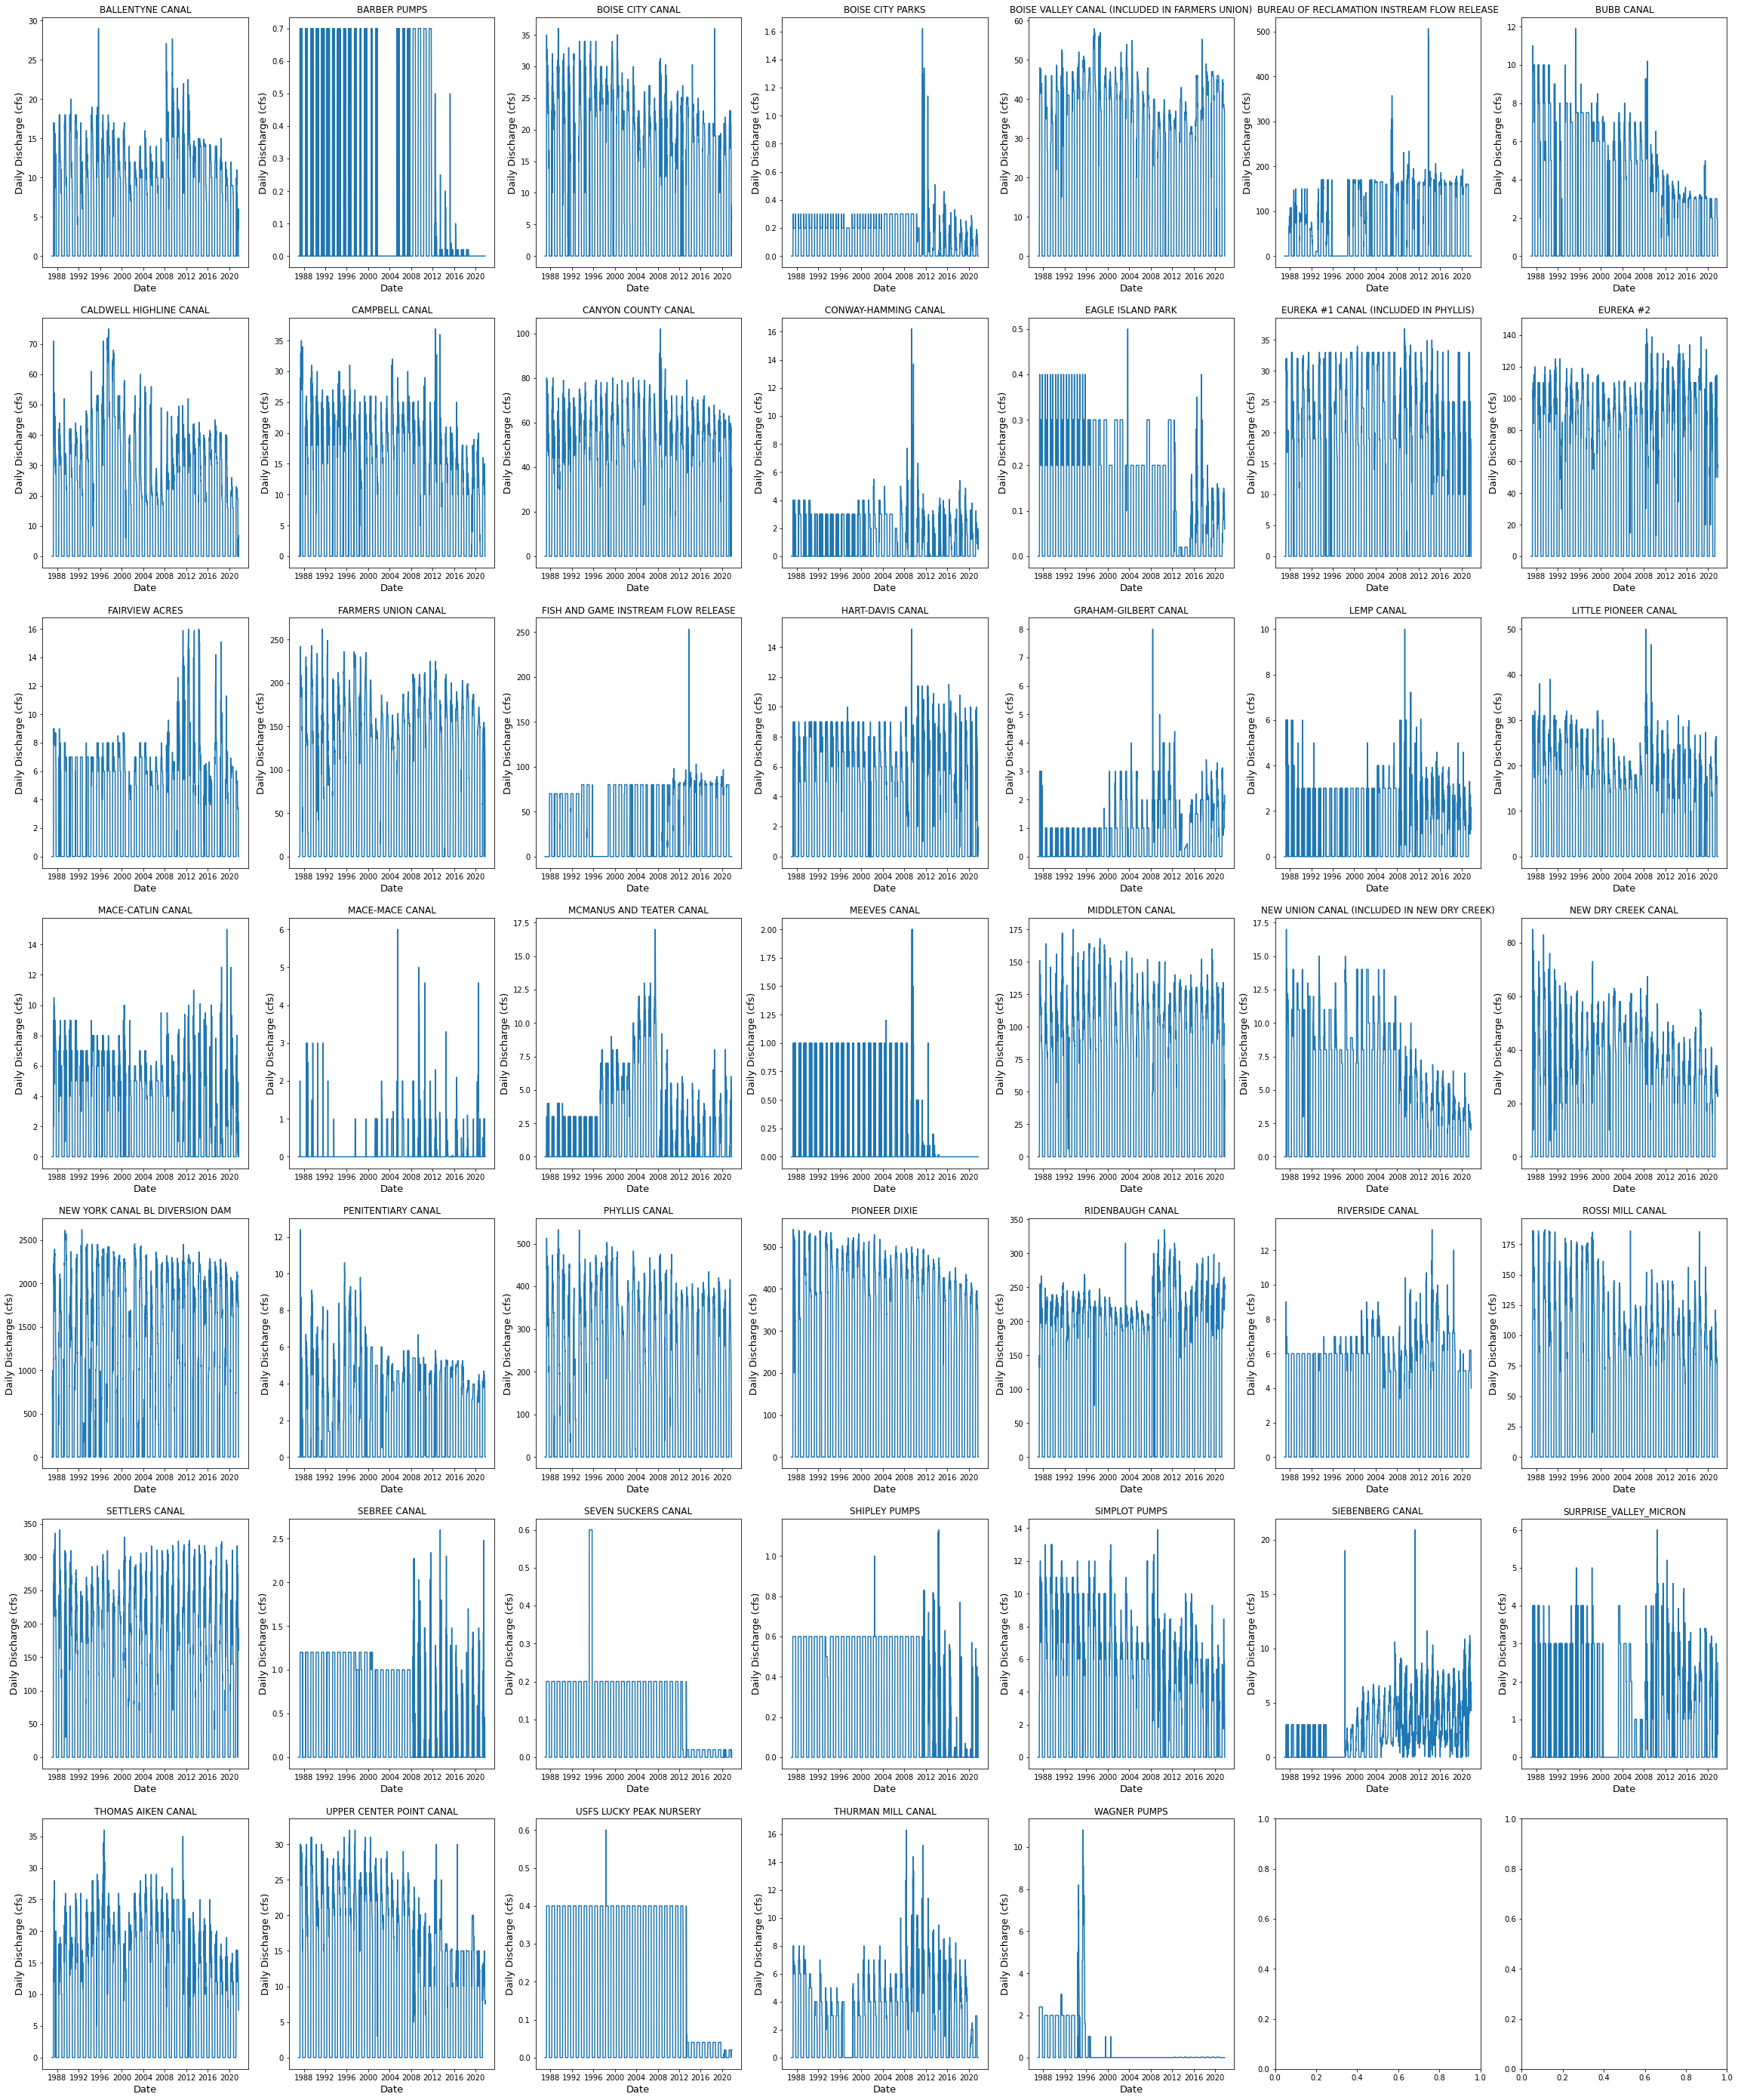

In [24]:
## PLOT THE RAW DATA TO VISUALLY ANALYZE TRENDS AND SEASONALITY

i,j = 0,0
plot_row = 7 #number of plots per row in figure
figure, ax = plt.subplots(7, plot_row, figsize=(40,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = canals[n] #takes an individual diversion point dataframe
  ax[i][j].plot(canal_data.index, canal_data['CFS'])
  ax[i][j].set_ylabel('Daily Discharge (cfs)', size=13)
  ax[i][j].set_xlabel('Date', size=13)
  ax[i][j].title.set_text(names[n])
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/rawdata.png')


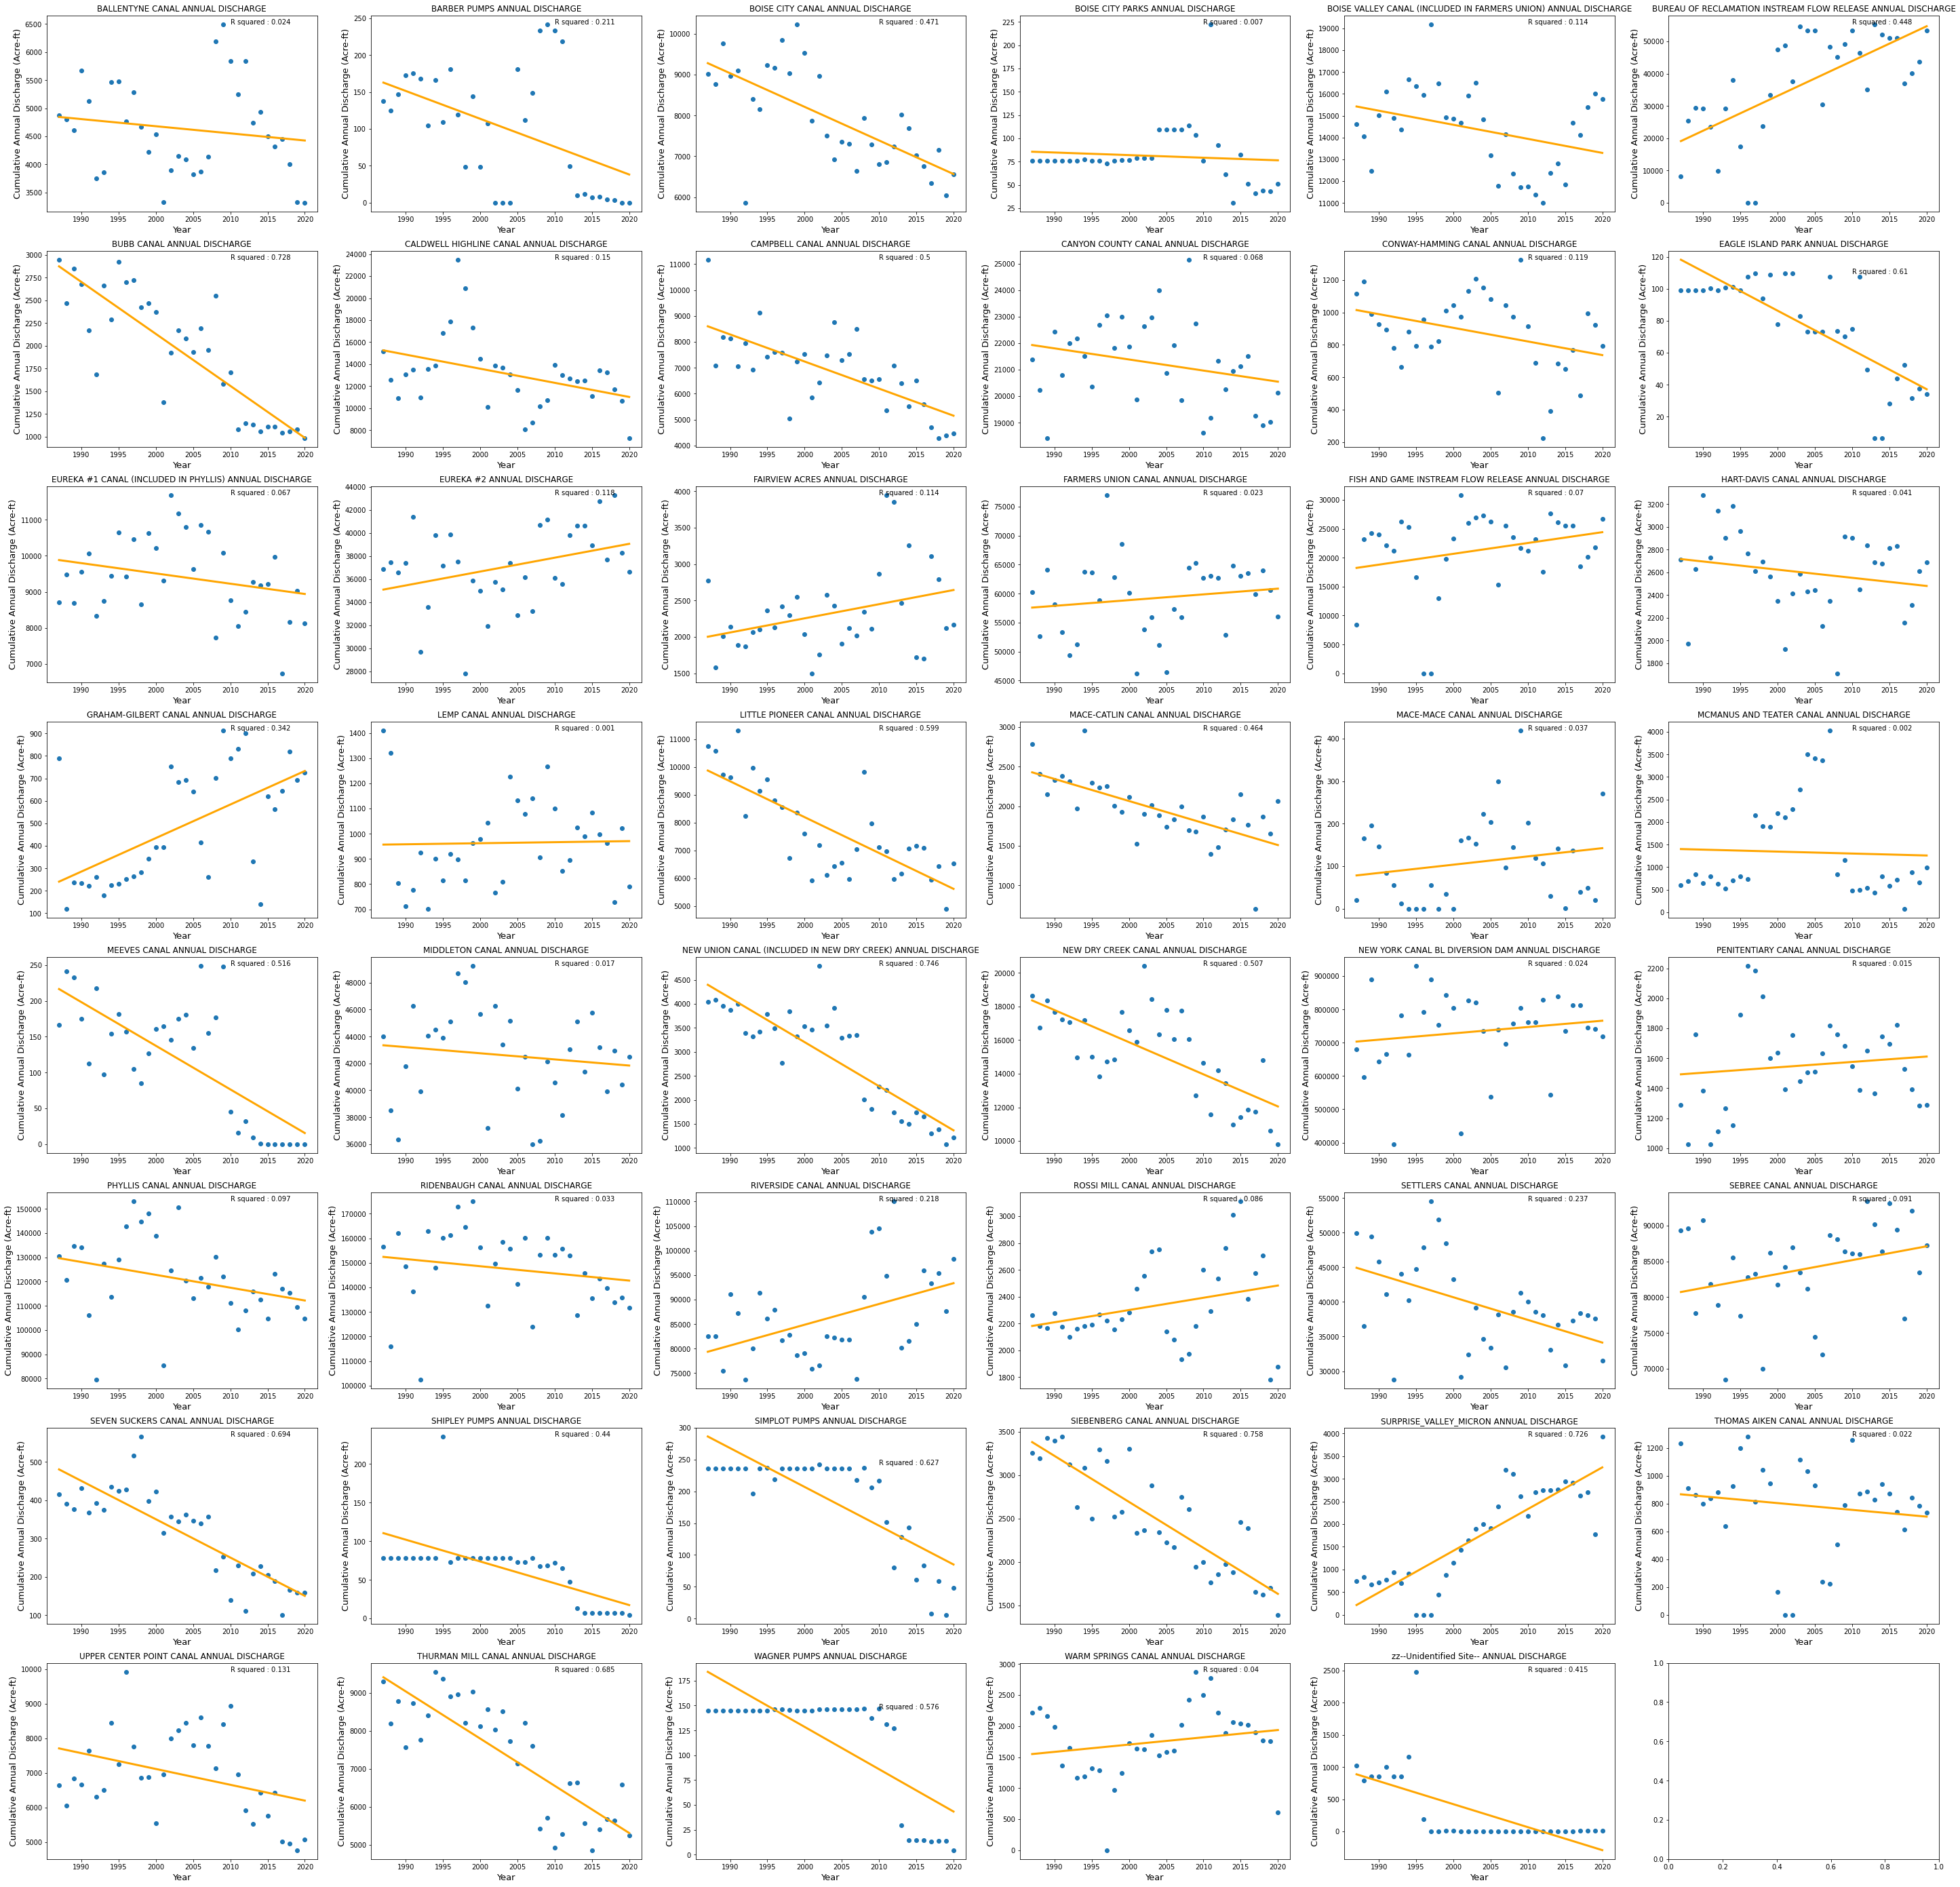

In [25]:
### FIND THE TOTAL WATER DIVERTED ANNUALLY ###

totals = np.empty((len(years), len(canals)))
totals_df = []

for i in range(len(canals)):
  tot_list = []
  for y in range(len(years)):
    sub_canal = canals[i]
    Ix = sub_canal.index.year == years[y] #index the year
    subset_year = sub_canal[Ix] #subset the data to the specified year
    totals[y][i] = sum(subset_year['Acre_feet']) #sum the total discharge throughout the year
    tot_list.append([years[y], sub_canal['DiversionName'][0], sum(subset_year['Acre_feet'])])
  tot_todf = pd.DataFrame(tot_list, columns = ['Year', 'Diversion Name', 'Total'])
  totals_df.append(tot_todf)

## CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(totals[:,i], regression[:,i]) #compares correlation of model to true values


## CREATE SUBPLOTS FOR THE CHART ##

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50,50)) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal = canals[n]
  canal_data = totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Cumulative Annual Discharge (Acre-ft)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal['DiversionName'][0]+' ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/totals.png')

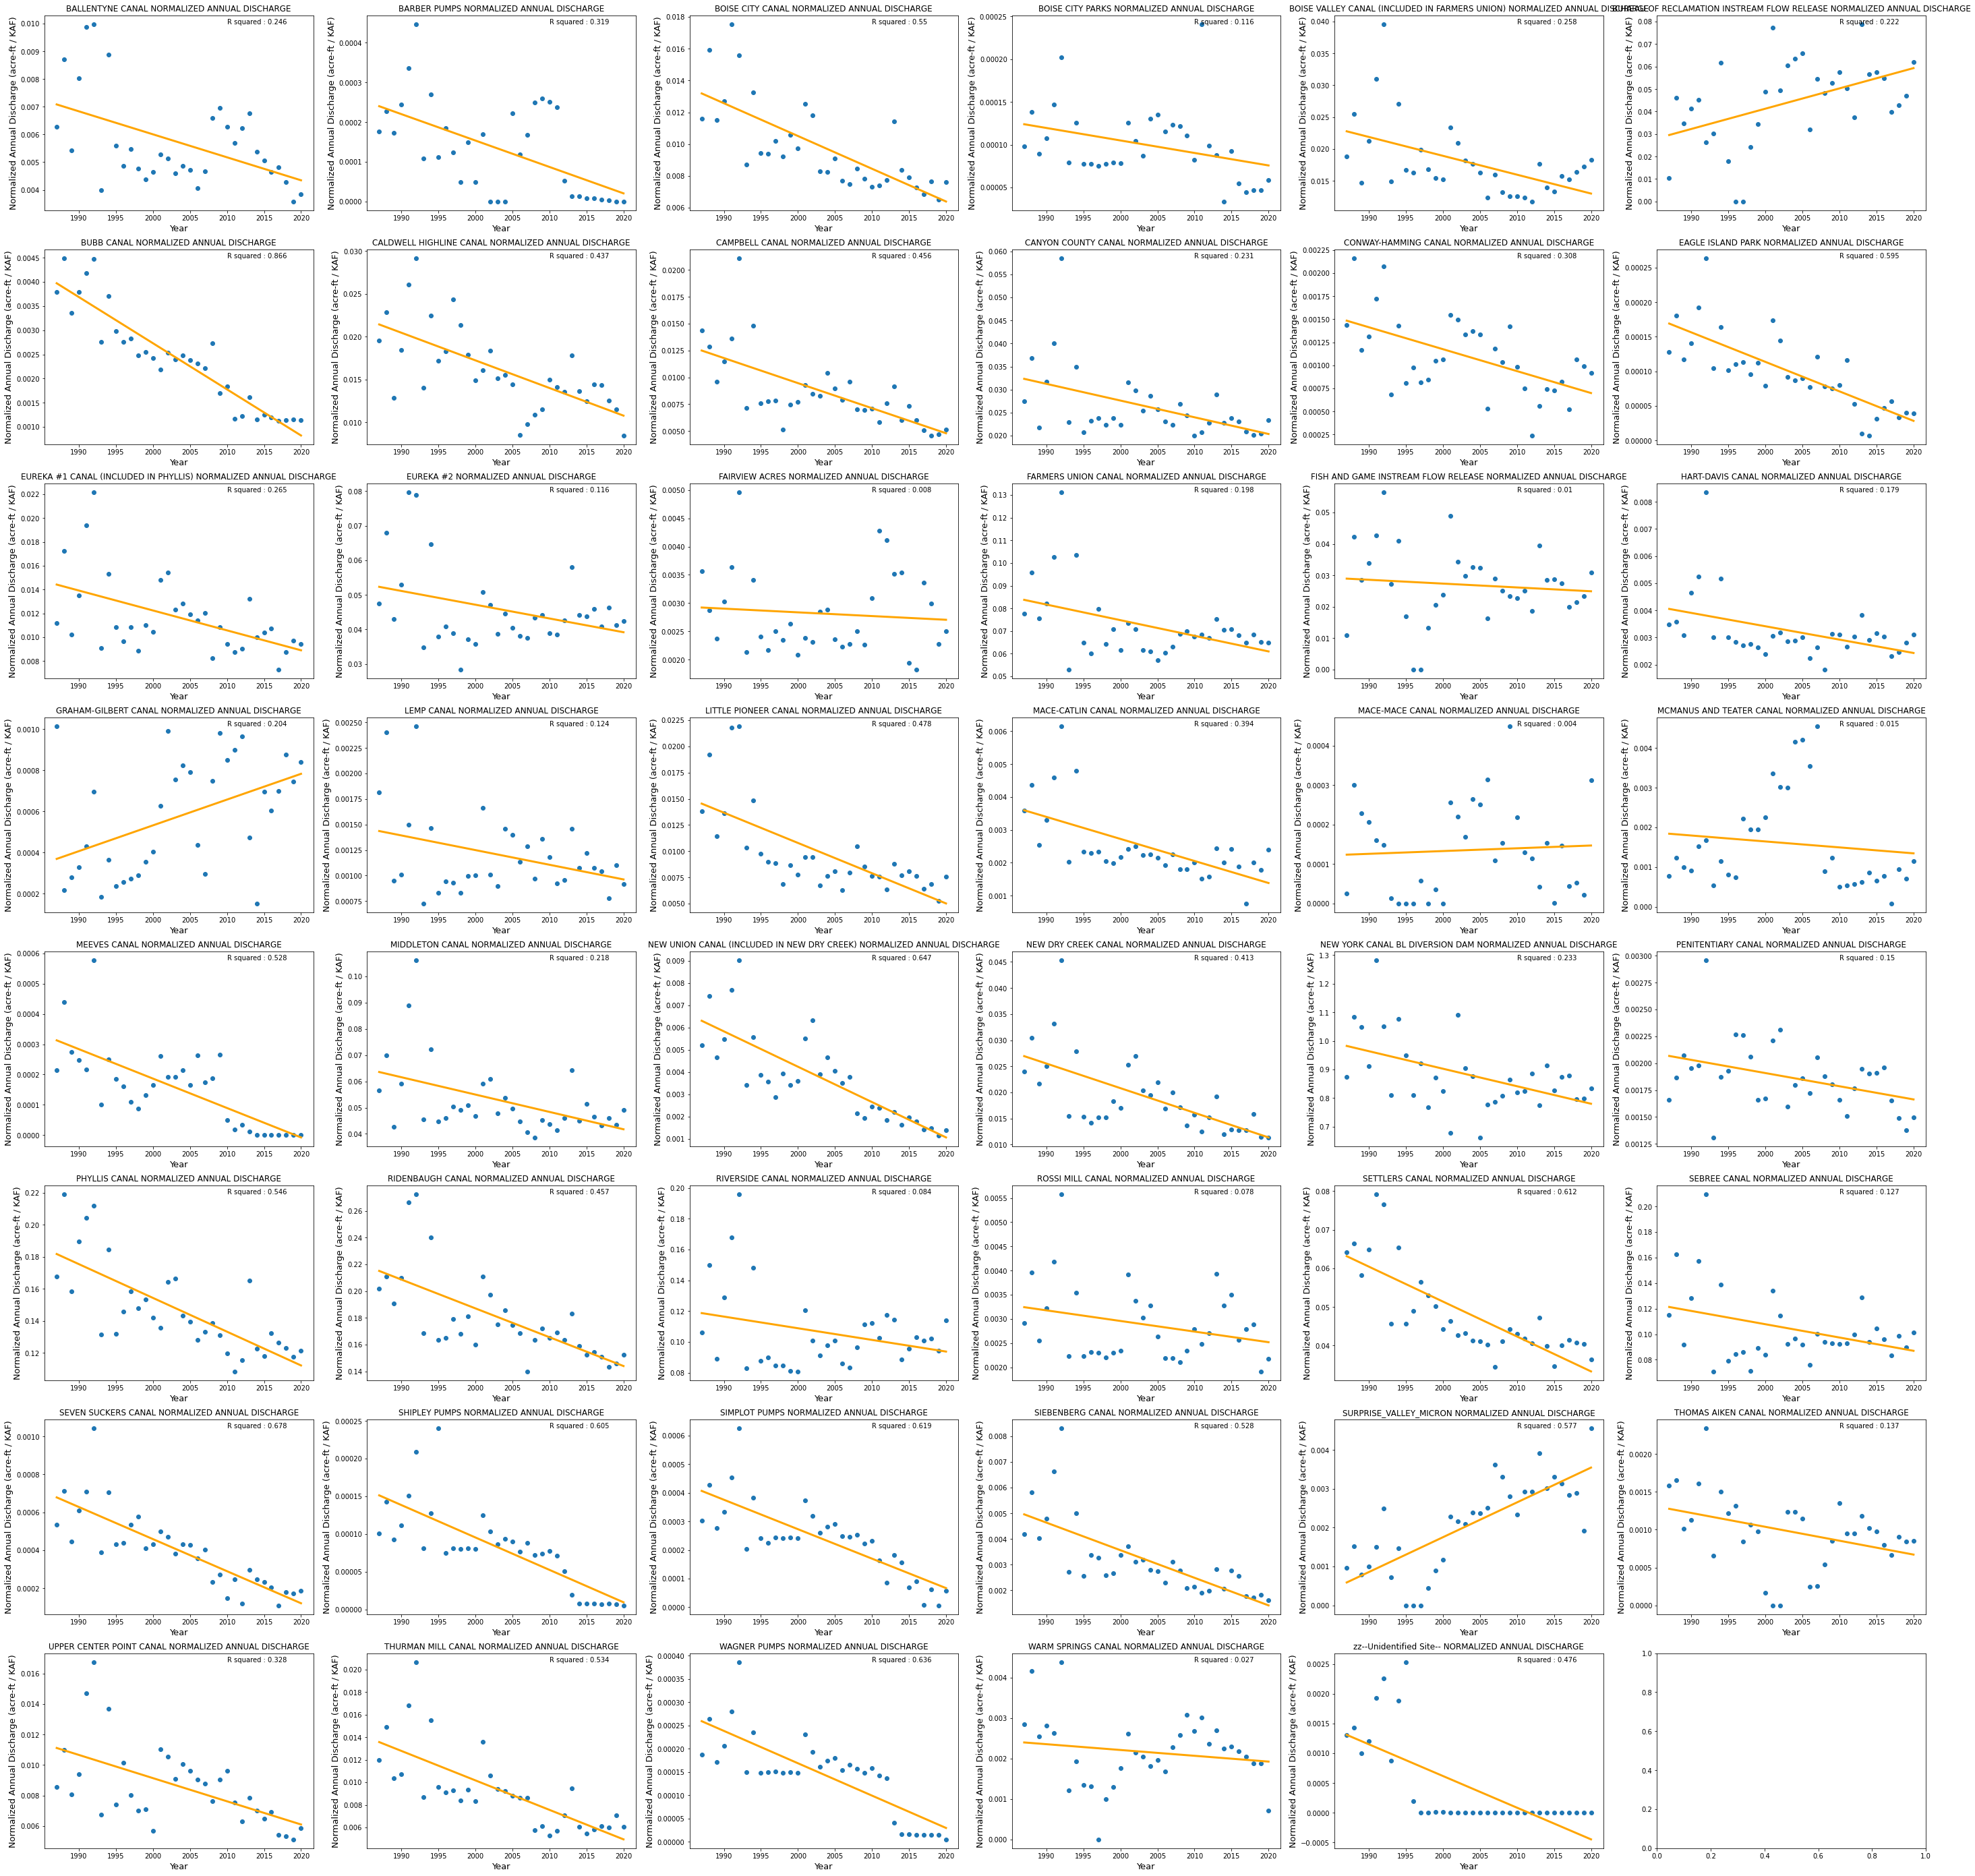

In [26]:
## Normalize total water diverted to the max fill available that year

norm_totals = np.empty((len(years), len(canals)))

for y in range(len(years)):
  for i in range(len(canals)):
    cum_discharge = totals[y][i]
    res_fill = max_fill['MaxFill'][max_fill['Year'] == years[y]]
    norm_totals[y][i] = cum_discharge/res_fill

# CALCULATE THE REGRESSION ##

regression = np.empty((len(years), len(canals)))
rsquared = np.empty(len(canals))

for i  in range(len(canals)):
  model = np.polyfit(years, norm_totals[:,i], deg=1) #runs regression for coefficients
  regression[:,i] = np.polyval(model, years) #uses x to predict model values
  rsquared[i] = metrics.r2_score(norm_totals[:,i], regression[:,i]) #compares correlation of model to true values

## Plot the normalized discharges

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50, 50)) #create the figure
for n in range(len(canals)): #run a for loop to add all plots to figure
  canal = canals[n]
  canal_data = norm_totals[:,n] #takes an individual diversion point datafram
  ax[i][j].plot(years, canal_data, 'o')
  ax[i][j].plot(years, regression[:,n], color = 'orange', linewidth=3)
  ax[i][j].set_ylabel('Normalized Annual Discharge (acre-ft / KAF)', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal['DiversionName'][0]+' NORMALIZED ANNUAL DISCHARGE')
  text = 'R squared : '+str(np.around(rsquared[n], 3))
  ax[i][j].text(2010, np.max(norm_totals[:,n]), s=text)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/norm_totals.png')


In [27]:
## CALCULATE BASIC VOLUME STATISTICS ##

stats = []

for i in range(len(canals)):
  canal = canals[i]
  avg = np.mean(canal['CFS'][canal['CFS'] != 0])
  std_dev = np.std(canal['CFS'][canal['CFS'] != 0])
  avg_vol = np.mean(canal['Acre_feet'][canal['Acre_feet'] != 0])
  std_dev_vol = np.std(canal['Acre_feet'][canal['Acre_feet'] != 0])
  coeff_var = std_dev/avg
  maximum = np.max(canal['CFS'])
  minimum = np.min(canal['CFS'][canal['CFS'] != 0])
  stats.append([canal['DiversionName'][0], avg, std_dev, coeff_var, avg_vol,
                std_dev_vol, maximum, minimum])

base_stats = pd.DataFrame(stats, columns = ['DiversionName', 'Mean Discharge(cfs)', 'Std_dev discharge(cfs)', 
                                            'Coefficient_Variation', 'Mean Volume (acre-ft per day)', 
                                            'Std_dev Volume (acre-ft per day)', 
                                            'Maximum', 'Minimum'])

base_stats.to_csv('datasets/diversion_timeseries/figures/stats.csv')



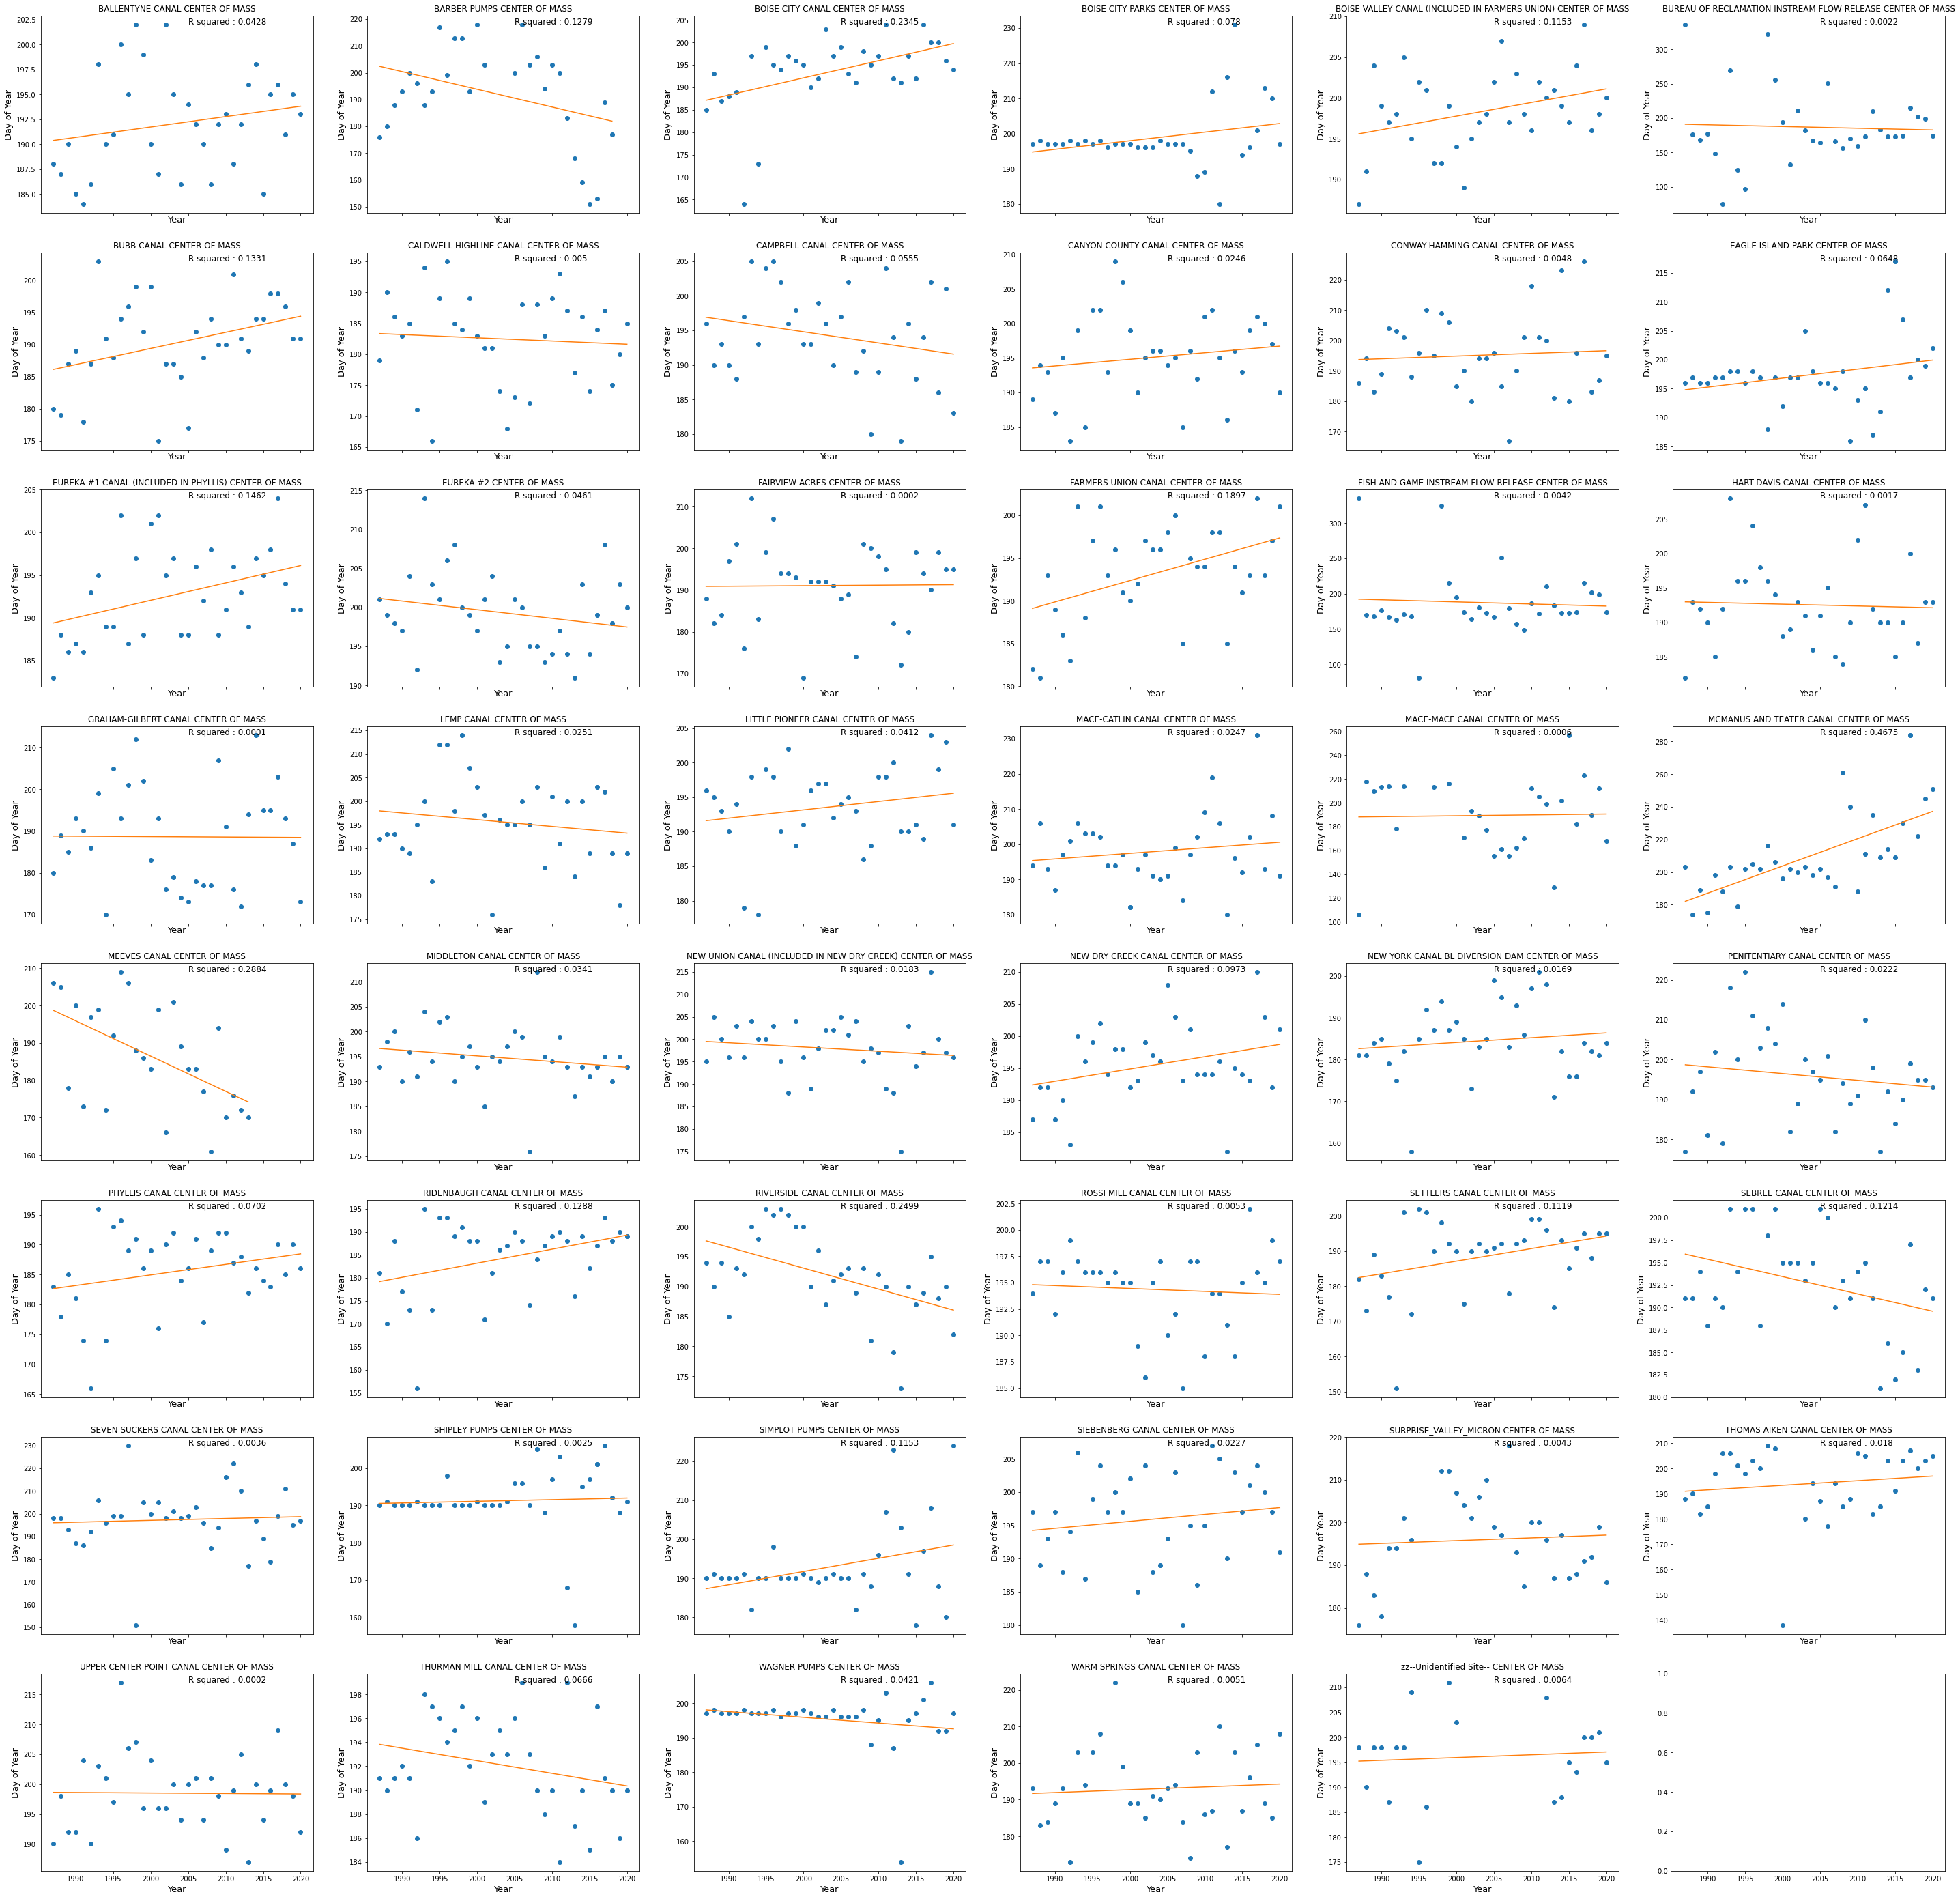

In [28]:
## FIND THE CENTER OF MASS OF THE IRRIGATION SEASON ##

centroid_df = []

for n in range(len(canals)):
  cent_list = []
  for i in range(len(years)):
    canal = canals[n]
    tots = totals_df[n]
    year = canal[canal.index.year == years[i]]
    tot_year = int(tots['Total'][tots['Year'] == years[i]])
    if tot_year == 0:
      None
    else:
      cent = round(np.sum(year.index.dayofyear*year['CFS'])/np.sum(year['CFS']))
      cent_list.append([years[i], canal['DiversionName'][0], cent])
  cent_todf = pd.DataFrame(cent_list, columns = ['Year', 'DiversionName', 'CentroidDay'])
  centroid_df.append(cent_todf)

## Check to see if there is a trend in the data through time

r_squared_df = []

for i in range(len(canals)):
  canal = centroid_df[i]
  model = np.polyfit(canal['Year'], canal['CentroidDay'], deg=1)
  canal['Model'] = np.polyval(model, canal['Year'])
  centroid_df[i] = canal
  r_squared = metrics.r2_score(canal['CentroidDay'], canal['Model'])
  r_squared_df.append([canal['DiversionName'][0], r_squared])

r_squared_df = pd.DataFrame(r_squared_df, columns =['DiversionName', 'RSquared'])

## PLOT THE DAY AT CENTER OF MASS FOR EACH CANAL ##

i,j = 0,0
plot_row = 6 #number of plots per row in figure
figure, ax = plt.subplots(8, plot_row, figsize=(50,50), sharex=True) #create the figure

for n in range(len(canals)): #run a for loop to add all plots to figure
  canal_data = centroid_df[n] #takes an individual diversion point dataframe
  r_squared = r_squared_df['RSquared'][n]
  ax[i][j].plot(canal_data['Year'], canal_data['CentroidDay'], 'o')
  ax[i][j].plot(canal_data['Year'], canal_data['Model'])
  ax[i][j].set_ylabel('Day of Year', size=13)
  ax[i][j].set_xlabel('Year', size=13)
  ax[i][j].title.set_text(canal_data['DiversionName'][0] +' CENTER OF MASS')
  ax[i][j].tick_params('both')
  ax[i][j].text(2005, np.max(canal_data['CentroidDay']), s='R squared : ' + str(np.around(r_squared, 4)), size=12)
  j+=1
  if j%plot_row==0:
    i+=1
    j=0
plt.savefig('datasets/diversion_timeseries/figures/centroid_time.png')

In [29]:
## FIND OTHER IRRIGATION SEASON TIMING METRICS ##

## Create a dataframe housing info:                 ##
## ------------------------------------------------ ##
## Column 1: Name of diversion                      ##
## Column 2: Date start of Irrigation season        ##
## Column 3: Day of year start of Irrigation season ##
## Column 4: Date end of irrigation season          ##
## Column 5: Date of year end of Irrigation season  ##
## Column 6: Length of Irrigation Season            ##
## ------------------------------------------------ ##

season_df = []

## Add a column to original canals dataframe to get the daily cumulative sum of 
#  discharge each year during the irrigation season (used for start and end days)
for i in range(len(canals)):
  for j in range(len(years)):
    sub_canal = canals[i]
    canals[i]['Sum'] = sub_canal.groupby(sub_canal.index.year)['CFS'].cumsum()

for i in range(len(canals)):
  length = []
  for y in range(len(years)):
    canal_data = canals[i]
    canal_name = canal_data['DiversionName'][1]
    canal_by_year = canal_data[canal_data.index.year == years[y]]
    if np.max(canal_by_year['Sum']) != 0:
      min_Ix = np.where(canal_by_year['Sum'] == np.min(canal_by_year['Sum']))
      min_Ix = min_Ix[0]
      min_Ix = min_Ix[-1]
      start_date = canal_by_year.index[min_Ix]
      start_dayofyear = canal_by_year.index.dayofyear[min_Ix]
    else:
      start_date = 'NaN'
      start_dayofyear = 'NaN'
    if np.max(canal_by_year['Sum'] != 0):
      max_Ix = np.where(canal_by_year['Sum'] == np.max(canal_by_year['Sum']))
      max_Ix= max_Ix[0]
      max_Ix = max_Ix[0]
      end_date = canal_by_year.index[max_Ix]
      end_dayofyear = canal_by_year.index.dayofyear[max_Ix]
    else: 
      end_date = 'NaN'
      end_dayofyear ='NaN'
    if end_date != 'NaN':
      irrig_season_range = end_dayofyear-start_dayofyear
    else: 
      irrig_season_range == 'NaN'
    length.append([canal_name, start_date, start_dayofyear, end_date, end_dayofyear, irrig_season_range])
  length_df = pd.DataFrame(length, columns = ['DiversionName', 'StartDate', 'StartDayofYear',
                                            'EndDate', 'EndDayofYear', 'Range'])
  season_df.append(length_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the

In [30]:
## BASIC STATISTICS ON TIMING ##

time_stats = []

for i in range(len(canals)):
  cent = centroid_df[i]
  canal_timing = season_df[i]
  avg_start = np.mean(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  std_start = np.std(canal_timing['StartDayofYear'][canal_timing['StartDayofYear'] != 'NaN'])
  avg_end = np.mean(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  std_end = np.std(canal_timing['EndDayofYear'][canal_timing['EndDayofYear'] != 'NaN'])
  avg_length = np.mean(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  std_length = np.std(canal_timing['Range'][canal_timing['Range'] != 'NaN'])
  avg_centroid = np.mean(cent['CentroidDay'])
  std_centroid = np.std(cent['CentroidDay'])
  time_stats.append([cent['DiversionName'][0], avg_start, std_start, avg_end, std_end, avg_length, 
                     std_length, avg_centroid, std_centroid])
  
time_stats = pd.DataFrame(time_stats, columns = ['DivName', 'avg_start', 'std_start', 
                                                 'avg_end','std_end', 'avg_length', 
                                                 'std_length','avg_centroid', 'std_centroid'])

time_stats.to_csv('datasets/diversion_timeseries/figures/time_stats.csv')

In [31]:
## Test if time series is stationary ##
## Mann_Kendall Test : A nonparametric test often used to detect changes in streamflow

# Test if volume time series is stationary
outs = []

for i in range(len(canals)):
  canal = canals[i]
  input = np.array(canal['CFS'])
  test = mk.seasonal_test(input, period=365, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_out = pd.DataFrame(outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_out)

# Test to see if annual time series is stationary 

annual_outs = []

for i in range(len(canals)):
  canal = canals[i]
  annual = totals[:,i]
  test = mk.original_test(annual, alpha = 0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  annual_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])
  
mannkend_annual = pd.DataFrame(annual_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
# display(mannkend_annual)
mannkend_annual.to_csv('datasets/diversion_timeseries/figures/mannkend_annual.csv')

# Test if length of irrigation season time series is stationary

length_outs = []

for i in range(len(canals)):
  canal = season_df[i]
  input = np.array(canal['Range'][canal['Range'] != 'NaN'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope, intercept = [test.trend, test.h, test.p, test.slope, test.intercept]
  length_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope, intercept])

mannkend_length = pd.DataFrame(length_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope', 'Intercept'])
display(mannkend_length)

# Test if centroid time series is stationary

centroid_outs = []

for i in range(len(canals)):
  canal = centroid_df[i]
  input = np.array(canal['CentroidDay'])
  test = mk.original_test(input, alpha=0.05)
  trend, hyp, pval, slope = [test.trend, test.h, test.p, test.slope]
  centroid_outs.append([canal['DiversionName'][0], trend, hyp, pval, slope])

mannkend_centroid = pd.DataFrame(centroid_outs, columns = ['Name', 'Trend', 'Hypothesis', 'Pvalue', 'Slope'])
# display(mannkend_centroid)




,Name,Trend,Hypothesis,Pvalue,Slope,Intercept
0,BALLENTYNE CANAL,no trend,False,1.996884e-01,-0.125000,188.562500
1,BARBER PUMPS,no trend,False,4.573036e-01,0.363636,143.500000
2,BOISE CITY CANAL,no trend,False,1.409054e-01,0.142857,181.642857
3,BOISE CITY PARKS,no trend,False,9.877113e-01,0.000000,179.000000
4,BOISE VALLEY CANAL (INCLUDED IN FARMERS UNION),no trend,False,3.336713e-01,0.111111,182.166667
5,BUREAU OF RECLAMATION INSTREAM FLOW RELEASE,no trend,False,1.260685e-01,0.000000,364.000000
6,BUBB CANAL,increasing,True,1.016986e-02,0.357143,175.107143
7,CALDWELL HIGHLINE CANAL,no trend,False,5.115513e-01,-0.050000,186.825000
8,CAMPBELL CANAL,no trend,False,6.338821e-01,-0.041667,189.687500
9,CANYON COUNTY CANAL,no trend,False,1.055475e-01,-0.300000,194.950000


In [32]:
## Add trend from Mann Kendall Test to volume stats and timing stats dataframes

base_stats['AnnualTrend'] = mannkend_annual['Trend']
time_stats['CentTrend'] = mannkend_centroid['Trend']
time_stats['LengthTrend'] = mannkend_length['Trend']

In [33]:
## Calculate the annual percent change based on Mann Kendall slope and intercept

percent_change = []
for i in range(len(canals)):
  canal = canals[i]
  mann_row = mannkend_annual[mannkend_annual['Name'] == canal['DiversionName'][0]]
  if mann_row['Hypothesis'][i] == False:
    percent_change.append('Nan')
  elif str(mann_row['Trend'][i]) == 'increasing':
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (end_val-mann_row['Intercept'][i])/mann_row['Intercept'][i]
    percent_change.append(change)
  else:
    end_val = mann_row['Intercept'][i]+mann_row['Slope'][i]*34
    change = (mann_row['Intercept'][i]-end_val)/mann_row['Intercept'][i]
    percent_change.append(change)

base_stats['Intercept'] = mannkend_annual['Intercept']
base_stats['Slope(acre-ft)'] = mannkend_annual['Slope']
base_stats['PercentChange'] = percent_change

#Export an easy to read summary of each diversion
base_stats.to_csv('datasets/diversion_timeseries/figures/changethroughtime.csv')

In [34]:
## Group canals based on the amount of discharge ##
## --------------------------------------------- ## 

mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None

print(len(mean50inc))
print(len(mean50dec))
print(len(mean10inc))
print(len(mean10dec))
print(len(mean0inc))
print(len(mean0dec))

2
3
0
6
2
11


['BUBB CANAL']
['GRAHAM-GILBERT CANAL']
['LEMP CANAL']
['MACE-MACE CANAL']
['PENITENTIARY CANAL']
['SURPRISE_VALLEY_MICRON']
5
8
12


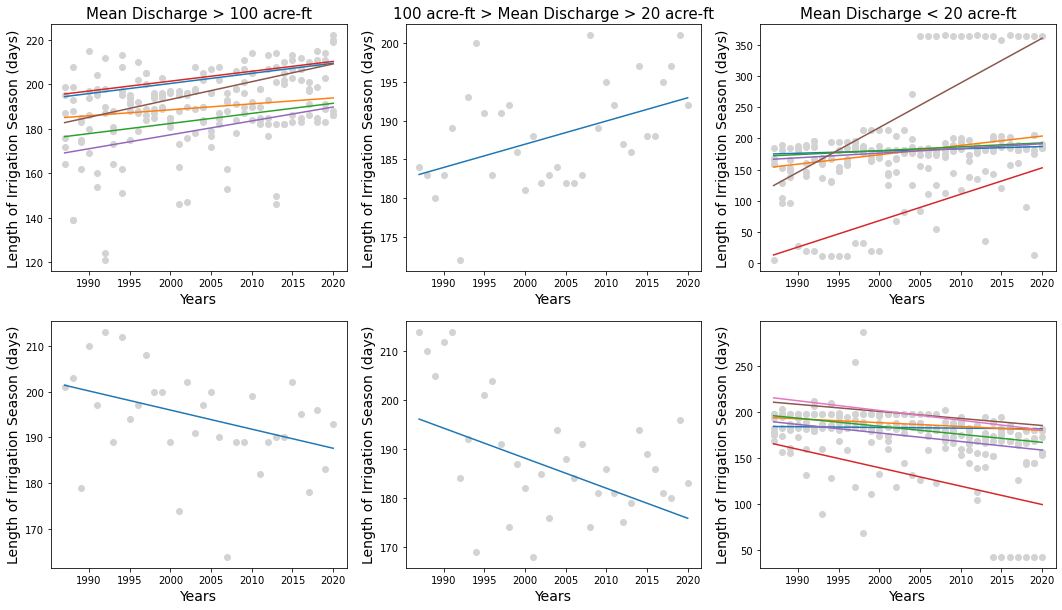

In [35]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

figure, ax = plt.subplots(2, 3, figsize = (18,10))
year_slope = np.arange(0,34,1)
text = 'No increasing diversions'

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  length = season_df[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 14)
    ax[0][0].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 14)
    ax[1][0].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 14)
    ax[0][1].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size = 15)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 14)
    ax[1][1].set_ylabel('Length of Irrigation Season (days)', size=14)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    ax[0][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 14)
    ax[0][2].set_ylabel('Length of Irrigation Season (days)', size=14)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, length['Range'], 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 14)
    ax[1][2].set_ylabel('Length of Irrigation Season (days)', size=14)
  else: 
    None

for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  elif vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'increasing':
    print([canal['Name']])
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope']*year_slope))
  else: 
    None

plt.savefig('datasets/diversion_timeseries/figures/results_length.svg')

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


In [36]:
mean50inc = []
mean50dec = []
mean10inc = []
mean10dec = []
mean0inc = []
mean0dec = []

for i in range(len(canals)):
  canal = base_stats.loc[i]
  length = mannkend_length.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'increasing':
    mean50inc.append(canal)
  elif canal['Mean Discharge(cfs)'] > 50 and length['Trend'] == 'decreasing':
    mean50dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'increasing':
    mean10inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and length['Trend'] == 'decreasing':
    mean10dec.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'increasing':
    mean0inc.append(canal)
  elif canal['Mean Discharge(cfs)'] < 10 and length['Trend'] == 'decreasing':
    mean0dec.append(canal)
  else: 
    None

print(len(mean50inc))
print(len(mean50dec))
print(len(mean10inc))
print(len(mean10dec))
print(len(mean0inc))
print(len(mean0dec))

6
1
1
1
6
7


In [37]:
## ---------------------------- ##
## CREATING FIGURES FOR RESULTS ## 
## ---------------------------- ##

## Change in Annual Volume Trends: 

for i in range(len(canals)):
  canal = base_stats.loc[i]
  ann_tots = totals[:,i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][0].set_xlabel('Years', size = 13)
    ax[0][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][0].set_title('Mean Discharge > 100 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][0].set_xlabel('Years', size = 13)
    ax[1][0].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][1].set_xlabel('Years', size = 13)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft')
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][1].set_xlabel('Years', size = 13)
    ax[1][1].set_ylabel('Annual Discharge (acre-ft)', size=13)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[0][2].set_xlabel('Years', size = 13)
    ax[0][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
    ax[0][2].set_title('Mean Discharge < 20 acre-ft', size=15)
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, ann_tots, 'o', color='lightgrey')
    ax[1][2].set_xlabel('Years', size = 13)
    ax[1][2].set_ylabel('Annual Discharge (acre-ft)', size=13)
  else: 
    ax[0][1].set_title('100 acre-ft > Mean Discharge > 20 acre-ft', size=15)
    ax[0][1].set_xlim([1987, 2021])
    ax[0][1].set_ylim([4000, 23000])
    ax[0][1].set_xlabel('Years', size=12)
    ax[0][1].set_ylabel('Annual Discharge (acre-ft)', size=12)
    # ax[0][1].text(1995, 17500, text)

for i in range(len(canals)):
  canal = base_stats.loc[i]
  if canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'increasing':
    ax[0][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] > 50 and canal['AnnualTrend'] == 'decreasing':
    ax[1][0].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 50 and canal['Mean Discharge(cfs)'] > 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][1].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'increasing':
    ax[0][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  elif canal['Mean Discharge(cfs)'] < 10 and canal['AnnualTrend'] == 'decreasing':
    ax[1][2].plot(years, (canal['Intercept']+canal['Slope(acre-ft)']*year_slope))
  else: 
    None

notrend50 = []
notrend10 = []
notrend0 = []
for i in range(len(canals)):
  canal = mannkend_length.loc[i]
  vol = base_stats.loc[i]
  if vol['Mean Discharge(cfs)'] > 50 and canal['Trend'] == 'no trend':
    notrend50.append(canal)
  elif vol['Mean Discharge(cfs)'] < 50 and vol['Mean Discharge(cfs)'] > 10 and canal['Trend'] == 'no trend':
    notrend10.append(canal)
  elif vol['Mean Discharge(cfs)'] < 10 and canal['Trend'] == 'no trend':
    notrend0.append(canal)
  else: 
    None

print(len(notrend50))
print(len(notrend10))
print(len(notrend0))


5
8
12
